# CORRELATION AND THE GENERAL LINEAR MODEL FOR ANALYSING BRAIN SCANS

Trying to understand the workings of the human mind is one of the most challenging question in modern days science. This is partly due to the fact that we cannot see or hear its activity directly. Even if we had transparent skulls a brain at sleep, during physical activity or while solving mathematical equations, it always looks the same.
The brains activity on a large scale can only be monitored indirectly. Various techniques have been developed over the years to get a glimps into the human brain at work. One of the most popular ones is functioal magnetic resonance imaging or fMRI. With fMRI you can use the oxygen concentrtion in the circulating blood to identify regions in the brain with high oxygen consumption. The measured signal is therefore also called the blood oxygen level dependend signal or BOLD.
The main assumption behind fMRI is that parts of the brain which are more "active" consume more oxygen which will be reflected in an increasing BOLD signal in these regions. While fMRI allows us to visualize the entire brain at large scale the BOLD signal however is only an indirect measure of its activity. Further the temporal resolution of fMRI is in the range of seconds while neurons (the nerve cells doing all the computations) operate in the range of milliseconds. 
Despite these drawbacks fMRI has proven to be a valuable tool to study how the brain works.

In the following I'll give you a brief idea about how fMRI data looks like and how it can be analysed to see where the oxygen is consumed.

We'll use Python for our analysis and code most of the functions ourselfs to get a better understanding of what is goin on and what the principles are.
So first we need Numpy for our numerical computaions and Matplotlib to visualize the results:

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

Next we need to get some brain imaging data.... http://www.fil.ion.ucl.ac.uk/spm/data/auditory/

In [64]:
data = np.genfromtxt('./fMRI_data/csv_data/slice_36.csv', delimiter=',')

Now lets define some variables according to the information provided by the lab

In [65]:
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

Lets first check the shape of the data matrix

In [66]:
print(data.shape)

(4096, 96)


 Alright that does not look like the correct form. Remember each image should be 64x64 voxels and each voxel should have 96 timepoints. So lets reshape the data.

In [67]:
data_ordered = data.reshape(x_size,y_size,acq_num)
print(data_ordered.shape)

(64, 64, 96)


Ok that looks better. Now if we average all time points for each voxel we should get a 64x64 matrix with the mean signal intensity. Lets check. 

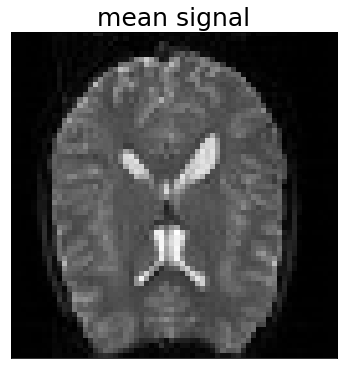

In [68]:
mean_data = data_ordered.mean(axis=2)

fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.imshow(mean_data, cmap='gray')
ax.set_title('mean signal', fontsize=25)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

OK that looks like a brain section, very good. Now how does the time course of a (random) voxel from this scan look like?

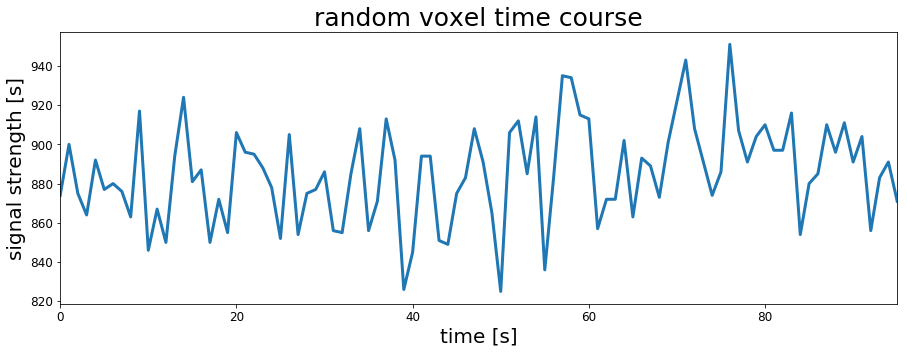

In [69]:
x_voxel = np.random.randint(64)
y_voxel = np.random.randint(64)

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ax.plot(data_ordered[x_voxel, y_voxel], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength [s]', fontsize=20)
ax.set_title('random voxel time course', fontsize=25)
ax.tick_params(labelsize=12)
plt.show()

OK this doesn't look like much. So lets think, how would you imagine the response to look like...

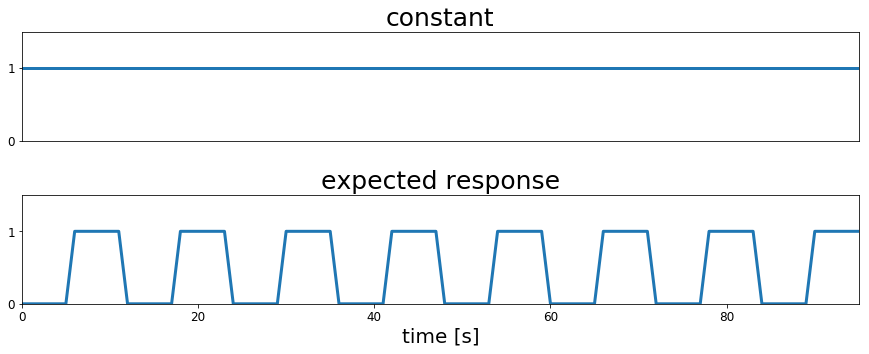

In [70]:
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

# Lets plot the design matrix
fig, ax = plt.subplots(2,1, figsize=(15, 5))

ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [s]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Well is this a good approximation to the response of the brain? If so we should see some voxel that has a similar timecourse right? So lets see how the voxels correlate with our assumption first.

In [71]:
c = np.corrcoef(design_matrix[1,:], data)[1:,0]

OK now which voxel correlates most with our prediction?

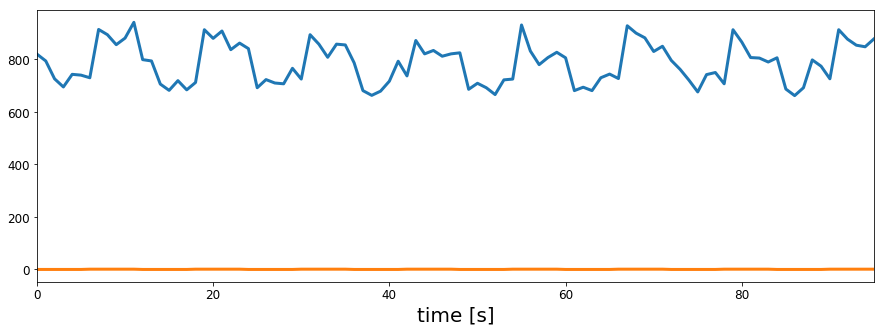

In [72]:
strongest_correlated = data[c.argmax(),:]

# Lets plot the timecourse 
fig, ax = plt.subplots(1,1,figsize=(15, 5))

ax.plot(strongest_correlated, lw=3)
ax.plot(design_matrix[1,:], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [s]', fontsize=20)
ax.tick_params(labelsize=12)

plt.show()

Yes the timecourse looks similar to our assumption but the data has a big offset. Lets normalise so we can visualize it better

In [73]:
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

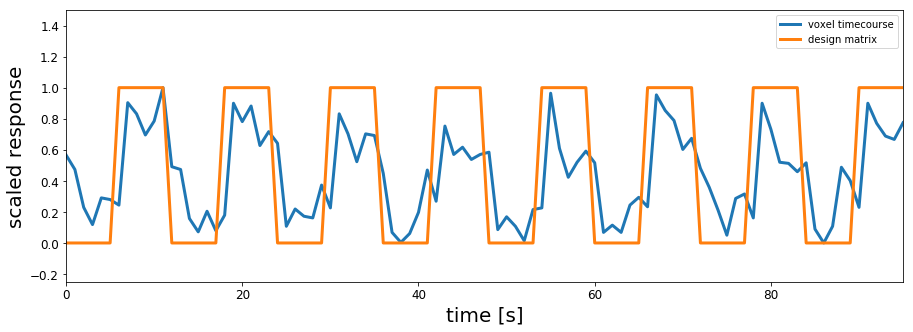

In [74]:
#data = z_score(data)
strongest_correlated_scaled = scale(data[c.argmax(),:])

# ...and plt the normalized timecourse
fig, (ax) = plt.subplots(1,1,figsize=(15, 5))

ax.plot(strongest_correlated_scaled, label='voxel timecourse', lw=3)
ax.plot(design_matrix[1,:], label='design matrix', lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(-0.25, 1.5)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('scaled response', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()


plt.show()

OK now we can see that the timecourse is looks similar to our assumption. But how are voxels that correlate with our idealized timecourse distributed within the brain? Lets check.

First we reshape the correlation vector to a 64x64 matrix. This should match the mean signal map we created before.
Second we can slect a threshold so that we only see voxels that have a correlation coefficiant higher than... lets say 0.2.

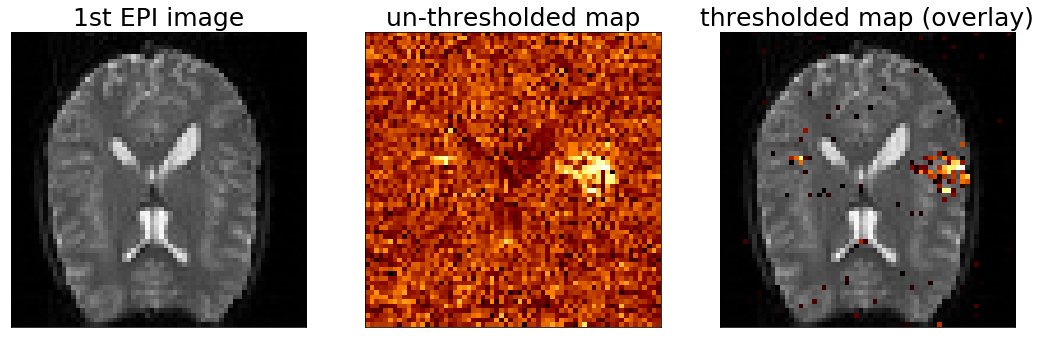

In [75]:
corr = c.reshape(x_size, y_size)
map = corr.copy()
map[map < 0.2] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(corr,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

PART II GLM

OK a bit noisy but clearly there is a cluster on the right side of the brain where the auditory cortex is located. Coincidence?

So now how can we improve on that. One popular method is to use a Generalized Linear Model (GLM)....

$$y=Xb+e$$

We will use the Ordinary least squares estimator to calculate b
$$b=(X'X)^{-1} X'y$$

Lets first import numpy and matplotlip to visualize our results

We can implement this as follows:

In [76]:
def do_GLM(X, y):
    
    if X.shape[1] > X.shape[0]:
        X = X.transpose()
    
    tmp   = np.linalg.inv(X.transpose().dot(X))
    tmp   = tmp.dot(X.transpose())

    beta  = np.zeros((y.shape[0], X.shape[1]))
    e     = np.zeros(y.shape)
    model = np.zeros(y.shape)
    r     = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        beta[i]  = tmp.dot(y[i,:].transpose())
        model[i] = X.dot(beta[i])
        e[i]     = (y[i,:] - model[i])
        r[i]     = np.sqrt(model[i].var()/y[i,:].var())
    
    return beta, model, e, r

Now lets run this and create the maps as we did it for the correlation analysis.

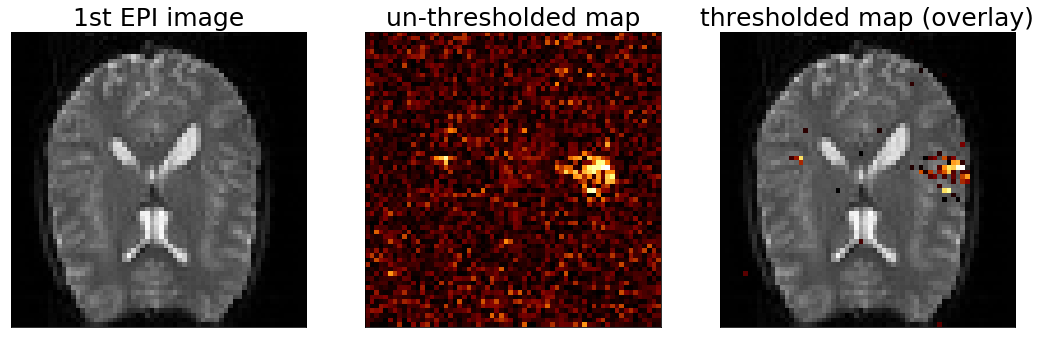

In [77]:
beta, model, e, r = do_GLM(design_matrix, data)

r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.3] = np.nan

fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

In [78]:
def z_score(data):
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    norm_data = (data-mean)/std
    return norm_data

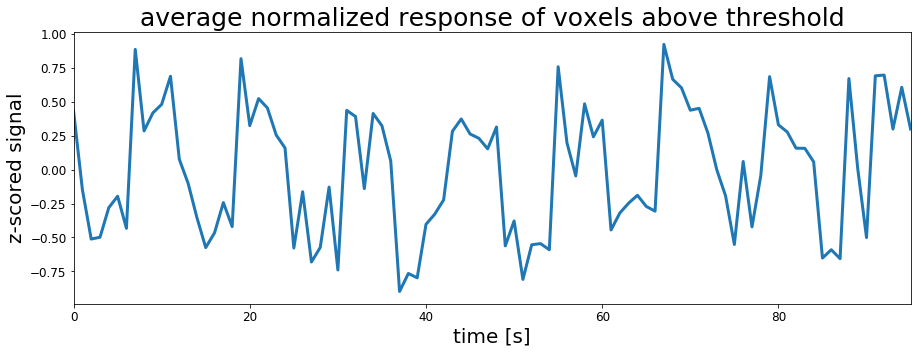

In [79]:
avg = z_score(data_ordered[~np.isnan(map),:])

# and plot the result
fig, ax = plt.subplots(1,1,figsize=(15, 5))

ax.plot(np.transpose(avg).mean(axis=1), lw=3)
ax.set_title('average normalized response of voxels above threshold', fontsize=25)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('z-scored signal', fontsize=20)
ax.tick_params(labelsize=12)

plt.show()

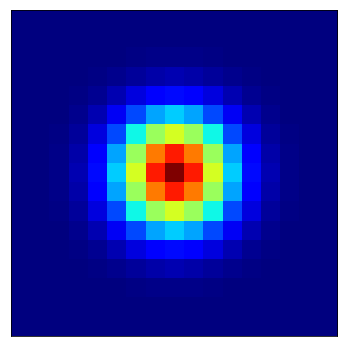

In [80]:
# TAKEN FROM: http://subsurfwiki.org/wiki/Gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(8)

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(gaussian_kernel_array, cmap='jet', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [81]:
# Adapted from: http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

def conv_image(image, input_kernel):
    # Flip the kernel
    kernel = np.flipud(np.fliplr(input_kernel))    
    
    # Create output array
    output = np.zeros_like(image)            
    
    # Determine size parameters
    m, n = kernel.shape[0]-1, kernel.shape[1]-1
    M, N = int((m/2)), int((n/2))
    
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + m, image.shape[1] + n))   
    image_padded[M:-M, N:-N] = image
    
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            
            output[y,x]=(kernel*image_padded[y:y +m+1, x:x +n+1]).sum() 
            #output[y,x]=(kernel*image_padded[y:y +m+1, x:x +n+1]).mean() 
    return output

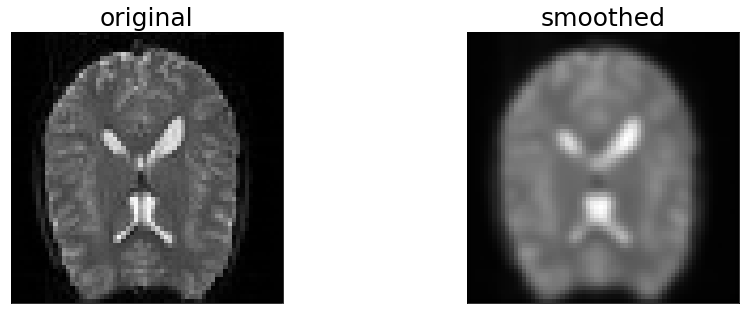

In [82]:
gaussian_kernel_array = gaussian_kernel(3)
smoothed_mean_data = conv_image(mean_data, gaussian_kernel_array)


#plt.imshow(smoothed_mean_data, cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('original', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(smoothed_mean_data, cmap='gray')
ax[1].set_title('smoothed', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

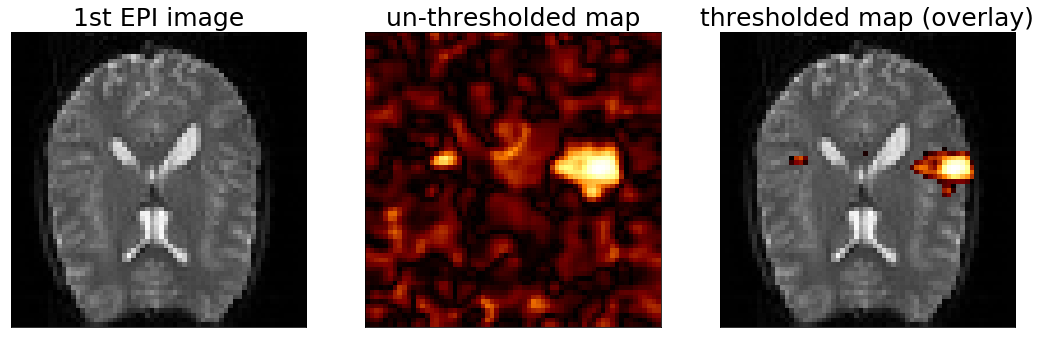

In [83]:
gaussian_kernel_array = gaussian_kernel(3)

data_smoothed = np.zeros_like(data_ordered)
for i in range(data_ordered.shape[2]):
    data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)
    
data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
beta, model, e, r = do_GLM(design_matrix, data_smoothed)

r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.35] = np.nan

fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

Finaly lets calculate and plot the maos for multiple slices...

C:\Users\Carsten\Anaconda3\lib\site-packages\matplotlib\colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\Carsten\Anaconda3\lib\site-packages\numpy\ma\core.py:710: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


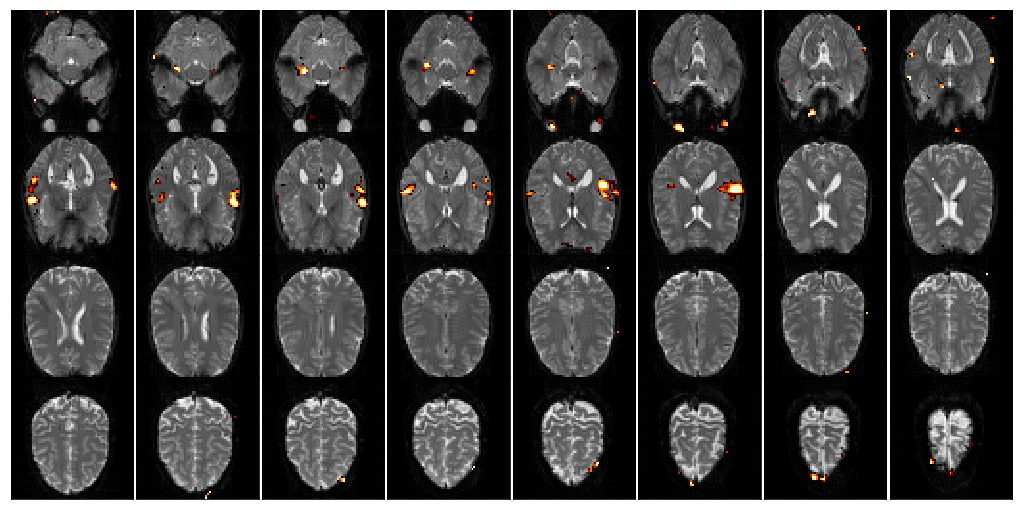

In [61]:
files = os.listdir('.\data')

n=0
m=0
fig, ax = plt.subplots(4, 8,figsize=(18, 9))
for i in files[23:55]:
    data = np.genfromtxt('data\{}'.format(i), delimiter=',')
    data_ordered = data.reshape(x_size,y_size,acq_num)
    mean_data = data_ordered.mean(axis=2)
    
    gaussian_kernel_array = gaussian_kernel(3)

    data_smoothed = np.zeros_like(data_ordered)
    for i in range(data_ordered.shape[2]):
        data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)

    data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
    beta, model, e, r = do_GLM(design_matrix, data_smoothed)
    
    r = r.reshape(x_size,y_size)
    map = r.copy()
    map[map<0.35] = np.nan

    #ax[n].set_title('Thresholded GLM activation map overlay')
    ax[n][m].set_xticks([])
    ax[n][m].set_yticks([])
    ax[n][m].imshow(mean_data, cmap='gray')
    ax[n][m].imshow(map, cmap='afmhot')
    
    if m==7:
        n +=1
        m = 0
    else:
        m +=1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()